In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import calendar
import time


In [140]:
# compute
PRECISION = 2

def unit_transform(numbers):
    if type(numbers) == list:
        return list(map(lambda x: round(x / 1000, PRECISION), numbers))
    else:
        return round(numbers / 1000, PRECISION)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom')

def custom_round(numbers):
    if type(numbers) == list:
        return list(map(lambda x: round(x, PRECISION), numbers))
    else:
        return round(numbers, PRECISION)

# Input Parameters

In [201]:
### loan
HOUSE_PRICE = unit_transform(422500)
DOWN_PAYMENT_RATIO = 0.20
MORTGAGE_YR = 15
INTEREST_RATE = 0.02875
TARGET_YR = 15
HOUSE_PRICE_YR_CHANGE = 0.1

# cost
HOA_MONTH = unit_transform(461)
MAINTAIN_YR = unit_transform(2000)
PROPERTY_TAX_YR = unit_transform(4000)

# income
RENT_MONTH = unit_transform(2500)

## Fundamental properties

In [202]:
HOA_YR = HOA_MONTH * 12
RENT_YR = RENT_MONTH * 12
RENTAL_HOME_PRICE_RATIO_YR = custom_round(RENT_YR / HOUSE_PRICE)

num_payment = MORTGAGE_YR * 12
interest_rate_month = INTEREST_RATE / 12
# Discount Factor (D) = {[(1 + i) ^n] - 1} / [i(1 + i)^n]
discount_factor = ((1 + interest_rate_month) ** num_payment - 1) / \
                  (interest_rate_month * (1 + interest_rate_month) ** num_payment)
down_payment = HOUSE_PRICE * DOWN_PAYMENT_RATIO
loan = HOUSE_PRICE - down_payment

# loan need to pay per month
loan_payment = loan / discount_factor
interest_total = loan_payment * num_payment - loan

title = f"house price:{HOUSE_PRICE}k, down payment ratio:{DOWN_PAYMENT_RATIO * 100}%, interest rate:{INTEREST_RATE * 100}%, mortgage year:{MORTGAGE_YR}\n"
title += f"yearly hoa:{HOA_YR}k, yearly maintain:{MAINTAIN_YR}k, yearly property tax:{PROPERTY_TAX_YR}k\n"
title += f"monthly rent:{RENT_MONTH}k, rental home price ratio:{RENTAL_HOME_PRICE_RATIO_YR}\n"
title += f"total loan:{loan}k, total interest:{custom_round(interest_total)}k, monthly loan payment:{custom_round(loan_payment)}\n"
print(title)

house price:422.5k, down payment ratio:20.0%, interest rate:2.875%, mortgage year:15
yearly hoa:5.5200000000000005k, yearly maintain:2.0k, yearly property tax:4.0k
monthly rent:2.5k, rental home price ratio:0.07
total loan:338.0k, total interest:78.5k, monthly loan payment:2.31



In [203]:
# data for each month
loan_cur = loan
loan_balance = [] # remaining loan at current month
principal_paid_month = [] # paid principal at each month
interest_paid_month = [] # paid interest at each month
income_month = [] # income at each month, deduct hoa, interest
expenses = [] # total paid house price till current month

# data for each year
house_price_cur = HOUSE_PRICE
loan_balance_yr = [] # remaining loan at current year
principal_paid_yr = [] # paid principal at each year
interest_paid_yr = [] # paid interest at each year
net_incomes_yr = [] # net income at each year
house_price_change_yr = [] # house price change at each year compared to last year
expenses_yr = [] # total paid house price till current year
yield_income_ratio_yr = [] # net_incomes_yr / expense
yield_ratio_yr = [] # net_incomes_yr + house_price / expense
yield_income_ratio_no_mortgage_yr = []
yield_ratio_no_mortgage_yr = []

# accumulate n years back.
acc_net_income_yr = [] # sum of net incomes till current year when doing mortgage
acc_net_income_no_mortgage_yr = [] # sum of net incomes till current year with full cash payment
acc_house_price_change_yr = [] # house_price at current year - initial price
acc_income_yield_ratio_yr = [] # acc_net_income_yr / expense
acc_income_yield_ratio_no_mortgage_yr = []  # acc_net_income_no_mortgage_yr / expense
acc_house_price_yield_ratio_yr = []  # acc_house_price_change_yr / expense
acc_house_price_yield_ratio_no_mortgage_yr = [] # acc_house_price_change_yr / expense(without mortgage)

In [204]:
for idx in range(1, TARGET_YR * 12 + 1):
    if idx <= num_payment:
        interest_part = loan_cur * interest_rate_month
        interest_paid_month.append(interest_part)
        principal_part = loan_payment - interest_part
        principal_paid_month.append(principal_part)
        loan_cur -= principal_part
        loan_balance.append(loan_cur)
        expenses.append(principal_paid_month[-1] + (expenses[-1] if expenses else down_payment))
        income_month.append(RENT_MONTH - interest_part - HOA_MONTH)
    else:
        assert loan_cur < 1
        loan_balance.append(0)
        principal_paid_month.append(0)
        interest_paid_month.append(0)
        expenses.append(int(expenses[-1]))
        income_month.append(RENT_MONTH - HOA_MONTH)

    # gather for year data
    if idx % 12 == 0:
        yrs = idx // 12
        # loan part
        loan_balance_yr.append(loan_balance[idx - 1])
        principal_paid_yr.append(sum(principal_paid_month[idx - 12: idx]))
        interest_paid_yr.append(sum(interest_paid_month[idx - 12: idx]))
        expenses_yr.append(expenses[idx - 1])
        # income part
        # already deduct hoa from income_month
        net_incomes_cur_yr = sum(income_month[idx - 12: idx]) - PROPERTY_TAX_YR - MAINTAIN_YR
        net_incomes_yr.append(net_incomes_cur_yr)
        # house price change part
        house_price_change_yr.append(house_price_cur * HOUSE_PRICE_YR_CHANGE)
        house_price_cur *= (1 + HOUSE_PRICE_YR_CHANGE)
        acc_house_price_change = house_price_cur - HOUSE_PRICE
        income_no_mortgage_yr = RENT_YR - PROPERTY_TAX_YR - MAINTAIN_YR - HOA_YR
        # yield each year
        yield_income_ratio_yr.append(net_incomes_yr[-1] / expenses_yr[-1] * 100)
        yield_ratio_yr.append((net_incomes_yr[-1] + house_price_change_yr[-1]) / expenses_yr[-1] * 100)
        yield_income_ratio_no_mortgage_yr.append(income_no_mortgage_yr/HOUSE_PRICE * 100)
        yield_ratio_no_mortgage_yr.append((income_no_mortgage_yr + house_price_change_yr[-1]) / HOUSE_PRICE * 100)
        # acc data
        acc_net_income_yr.append(sum(net_incomes_yr))
        acc_net_income_no_mortgage_yr.append(income_no_mortgage_yr * yrs)
        acc_income_yield_ratio_yr.append(acc_net_income_yr[-1] / expenses_yr[-1] * 100)
        acc_income_yield_ratio_no_mortgage_yr.append(acc_net_income_no_mortgage_yr[-1] / HOUSE_PRICE * 100)
        acc_house_price_change_yr.append(acc_house_price_change)
        acc_house_price_yield_ratio_yr.append(acc_house_price_change_yr[-1] / expenses_yr[-1] * 100)
        acc_house_price_yield_ratio_no_mortgage_yr.append(acc_house_price_change_yr[-1] / HOUSE_PRICE * 100)

debug = False
if debug:
    print(f"loan_balance:${custom_round(loan_balance)}\n")
    print(f"principal_paid_month:${custom_round(principal_paid_month)}\n")
    print(f"interest_paid_month:${custom_round(interest_paid_month)}\n")
    print(f"expenses:${custom_round(expenses)}\n")
    print(f"income_month:${custom_round(income_month)}\n")
    
debug = False
if debug:
    print(f"loan_balance_yr:${custom_round(loan_balance_yr)}\n")
    print(f"principal_paid_yr:${custom_round(principal_paid_yr)}\n")
    print(f"interest_paid_yr:${custom_round(interest_paid_yr)}\n")
    print(f"net_incomes_yr:${custom_round(net_incomes_yr)}\n")
    print(f"house_price_change_yr:${custom_round(house_price_change_yr)}\n")
    print(f"expenses_yr:${custom_round(expenses_yr)}\n")
    print(f"yield_income_ratio_yr:${custom_round(yield_income_ratio_yr)}\n")
    print(f"yield_ratio_yr:${custom_round(yield_ratio_yr)}\n")
    print(f"yield_income_ratio_no_mortgage_yr:${custom_round(yield_income_ratio_no_mortgage_yr)}\n")
    print(f"yield_ratio_no_mortgage_yr:${custom_round(yield_ratio_no_mortgage_yr)}\n")
    print(f"acc_net_income_yr:${custom_round(acc_net_income_yr)}\n")
    print(f"acc_net_income_no_mortgage_yr:${custom_round(acc_net_income_no_mortgage_yr)}\n")
    print(f"acc_house_price_change_yr:${custom_round(acc_house_price_change_yr)}\n")
    print(f"acc_income_yield_ratio_yr:${custom_round(acc_income_yield_ratio_yr)}\n")
    print(f"acc_income_yield_ratio_no_mortgage_yr:${custom_round(acc_income_yield_ratio_no_mortgage_yr)}\n")
    print(f"acc_house_price_yield_ratio_yr:${custom_round(acc_house_price_yield_ratio_yr)}\n")
    print(f"acc_house_price_yield_ratio_no_mortgage_yr:${custom_round(acc_house_price_yield_ratio_no_mortgage_yr)}\n")



Done!


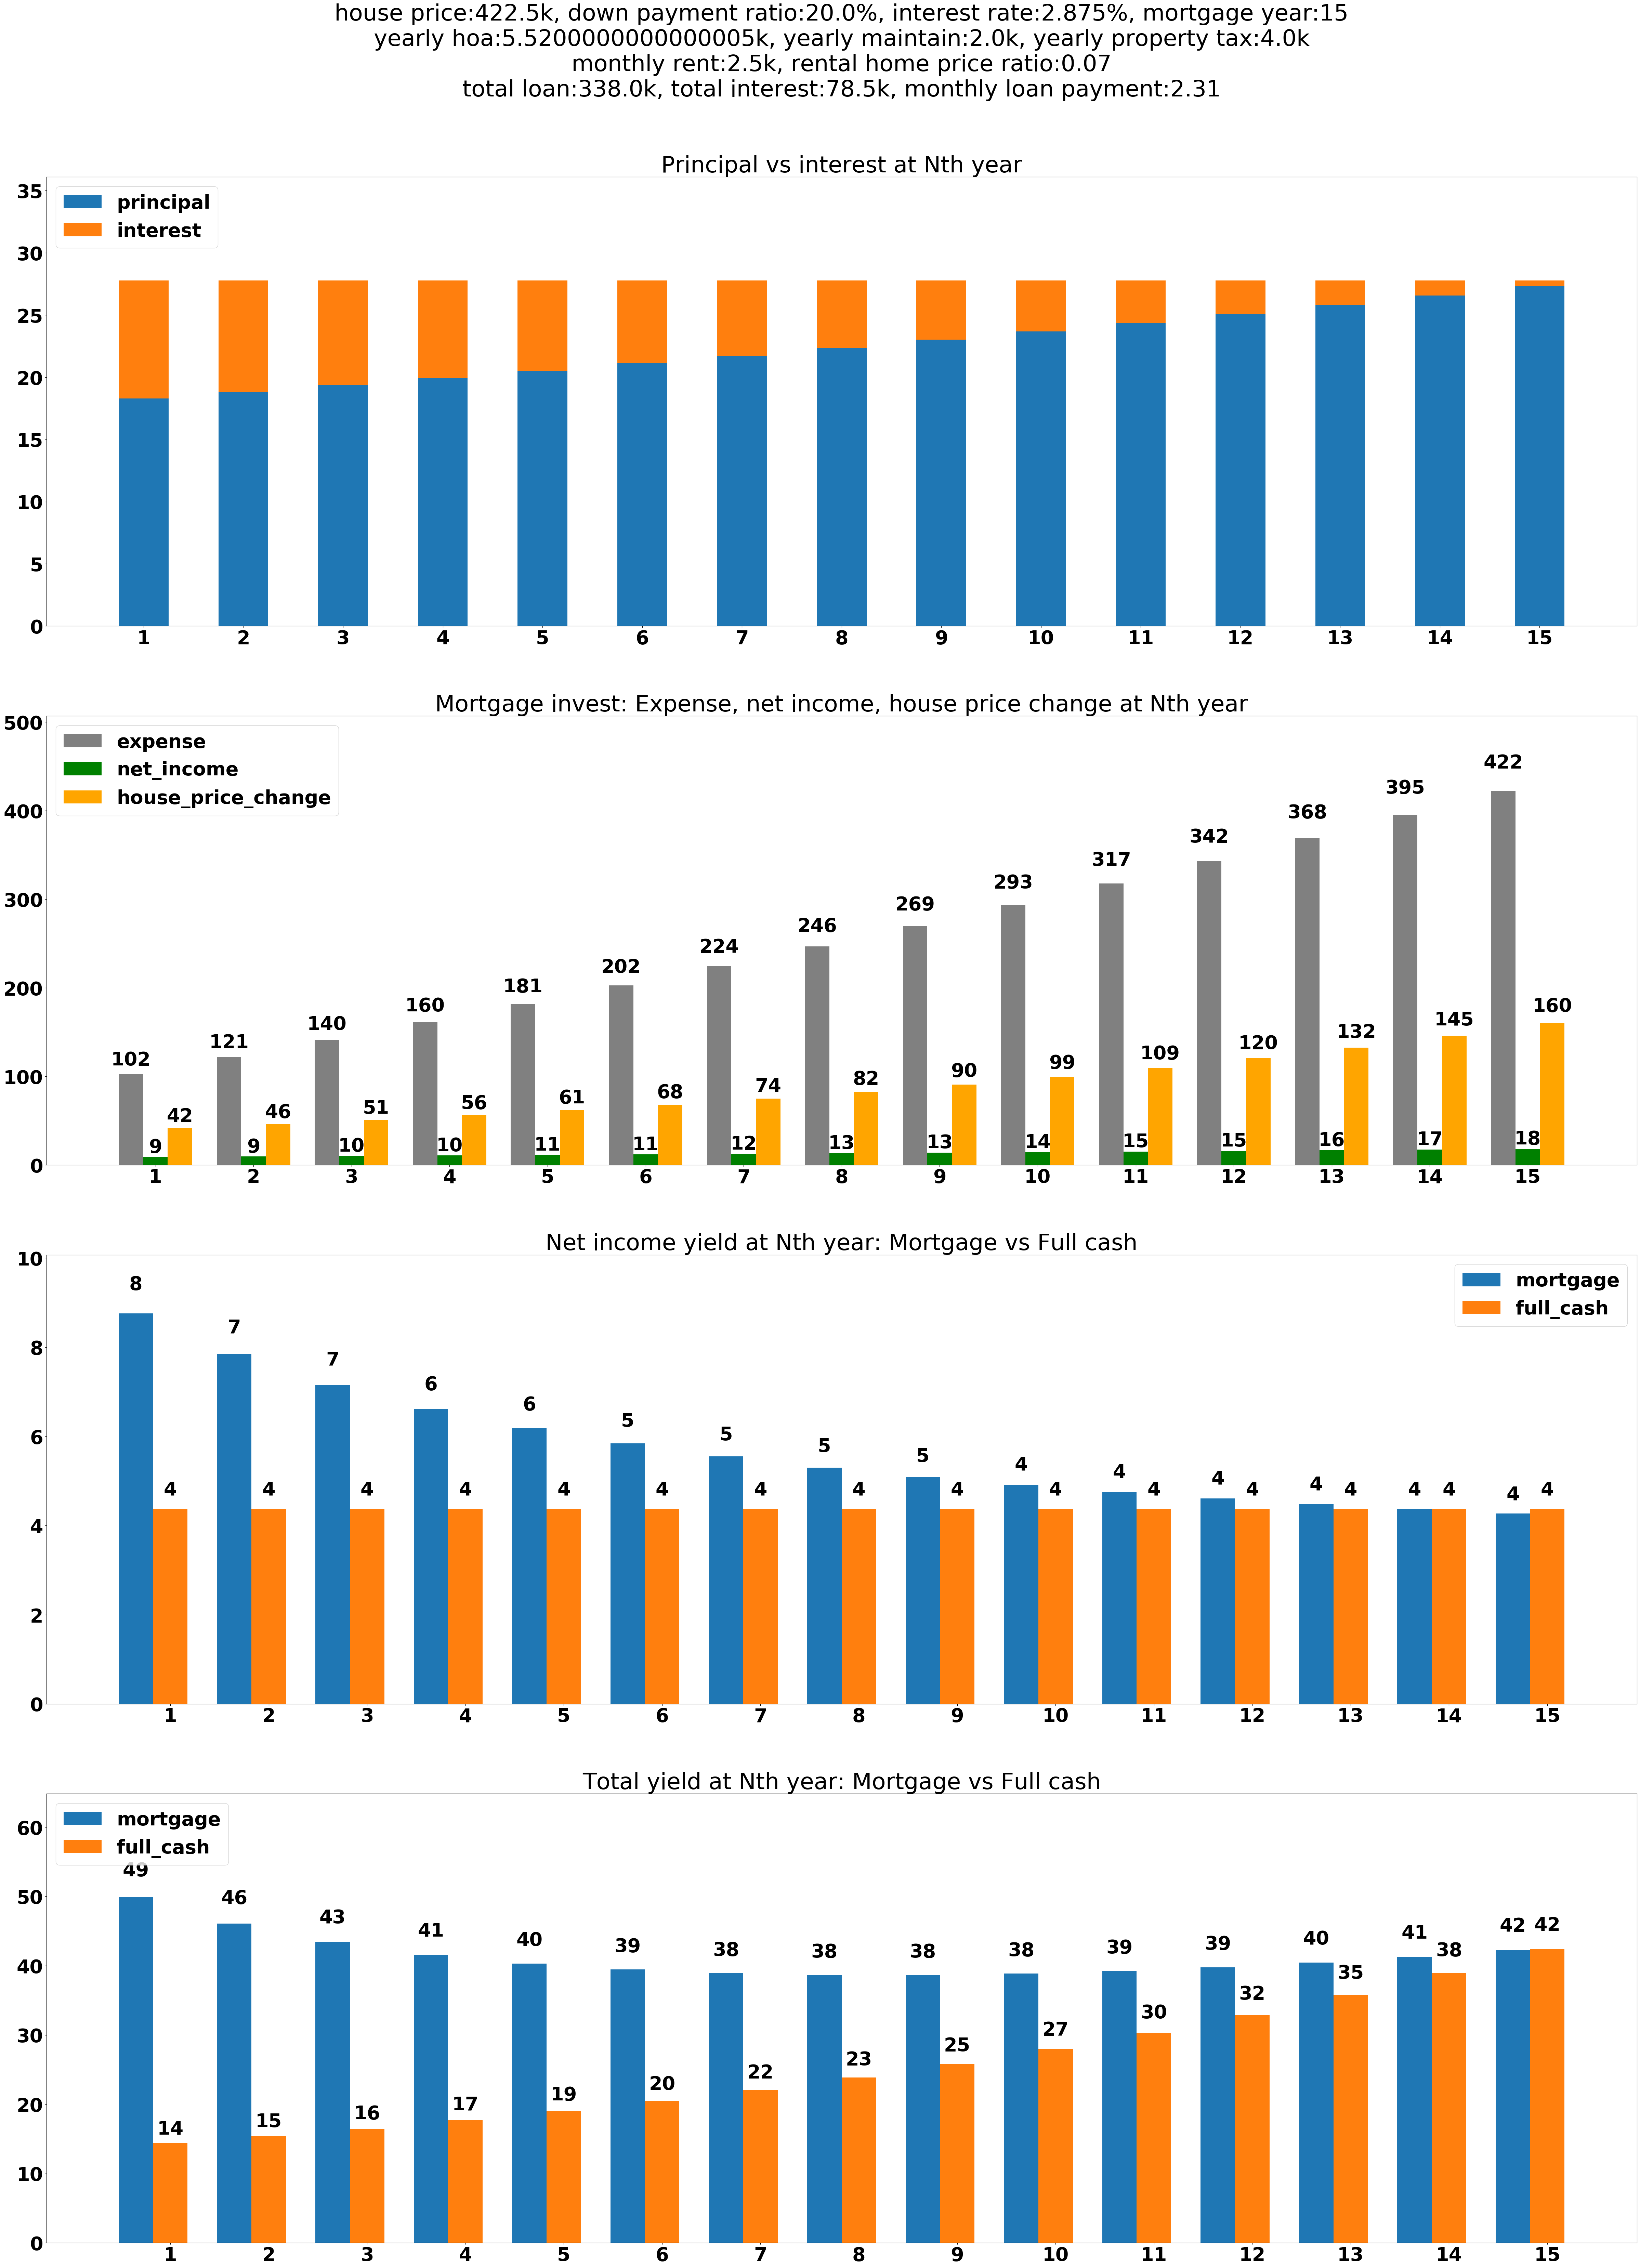

In [205]:
font = {'weight' : 'bold',
        'size'   : 40}
figure(num=None, figsize=(60, 80), dpi=100, facecolor='w', edgecolor='k')

plt.rc('font', **font)

target_yrs = np.arange(TARGET_YR)
plt.subplot(4,1,1)
width = 0.5
p_principal = plt.bar(target_yrs, principal_paid_yr, width)
p_interest = plt.bar(target_yrs, interest_paid_yr, width, bottom=principal_paid_yr)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, loan_payment *12 * 1.3)
plt.legend((p_principal[0], p_interest[0]), ('principal', 'interest'), loc=2)
plt.title("{}\n\nPrincipal vs interest at Nth year".format(title))

plt.subplot(4,1,2)
width = 0.25
p_expense = plt.bar(target_yrs-width, expenses_yr, width, color='grey')
p_net_income = plt.bar(target_yrs, net_incomes_yr, width, color='green')
p_house_price_change = plt.bar(target_yrs+width, house_price_change_yr, width, color='orange')
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, HOUSE_PRICE * 1.2)
plt.title("Mortgage invest: Expense, net income, house price change at Nth year")
plt.legend((p_expense[0], p_net_income[0], p_house_price_change[0]), ('expense', 'net_income', 'house_price_change'))
autolabel(p_expense)
autolabel(p_net_income)
autolabel(p_house_price_change)

plt.subplot(4,1,3)
width = 0.35
p_yield_income_ratio_yr = plt.bar(target_yrs-width, yield_income_ratio_yr, width)
p_yield_income_ratio_no_mortgage_yr = plt.bar(target_yrs, yield_income_ratio_no_mortgage_yr, width)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(yield_income_ratio_yr) * 1.15)
plt.title("Net income yield at Nth year: Mortgage vs Full cash")
plt.legend((p_yield_income_ratio_yr[0], p_yield_income_ratio_no_mortgage_yr[0]), ('mortgage', 'full_cash'))
autolabel(p_yield_income_ratio_yr)
autolabel(p_yield_income_ratio_no_mortgage_yr)

plt.subplot(4,1,4)
width = 0.35
p_yield_ratio_yr = plt.bar(target_yrs-width, yield_ratio_yr, width)
p_yield_ratio_no_mortgage_yr = plt.bar(target_yrs, yield_ratio_no_mortgage_yr, width)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(yield_ratio_yr) * 1.3)
plt.title("Total yield at Nth year: Mortgage vs Full cash")
plt.legend((p_yield_ratio_yr[0], p_yield_ratio_no_mortgage_yr[0]), ('mortgage', 'full_cash'), loc=2)
autolabel(p_yield_ratio_yr)
autolabel(p_yield_ratio_no_mortgage_yr)

# plt.show()
ts = calendar.timegm(time.gmtime())
# plt.savefig("Per_year_chart{}.png".format(ts))

print("Done!")

Done!


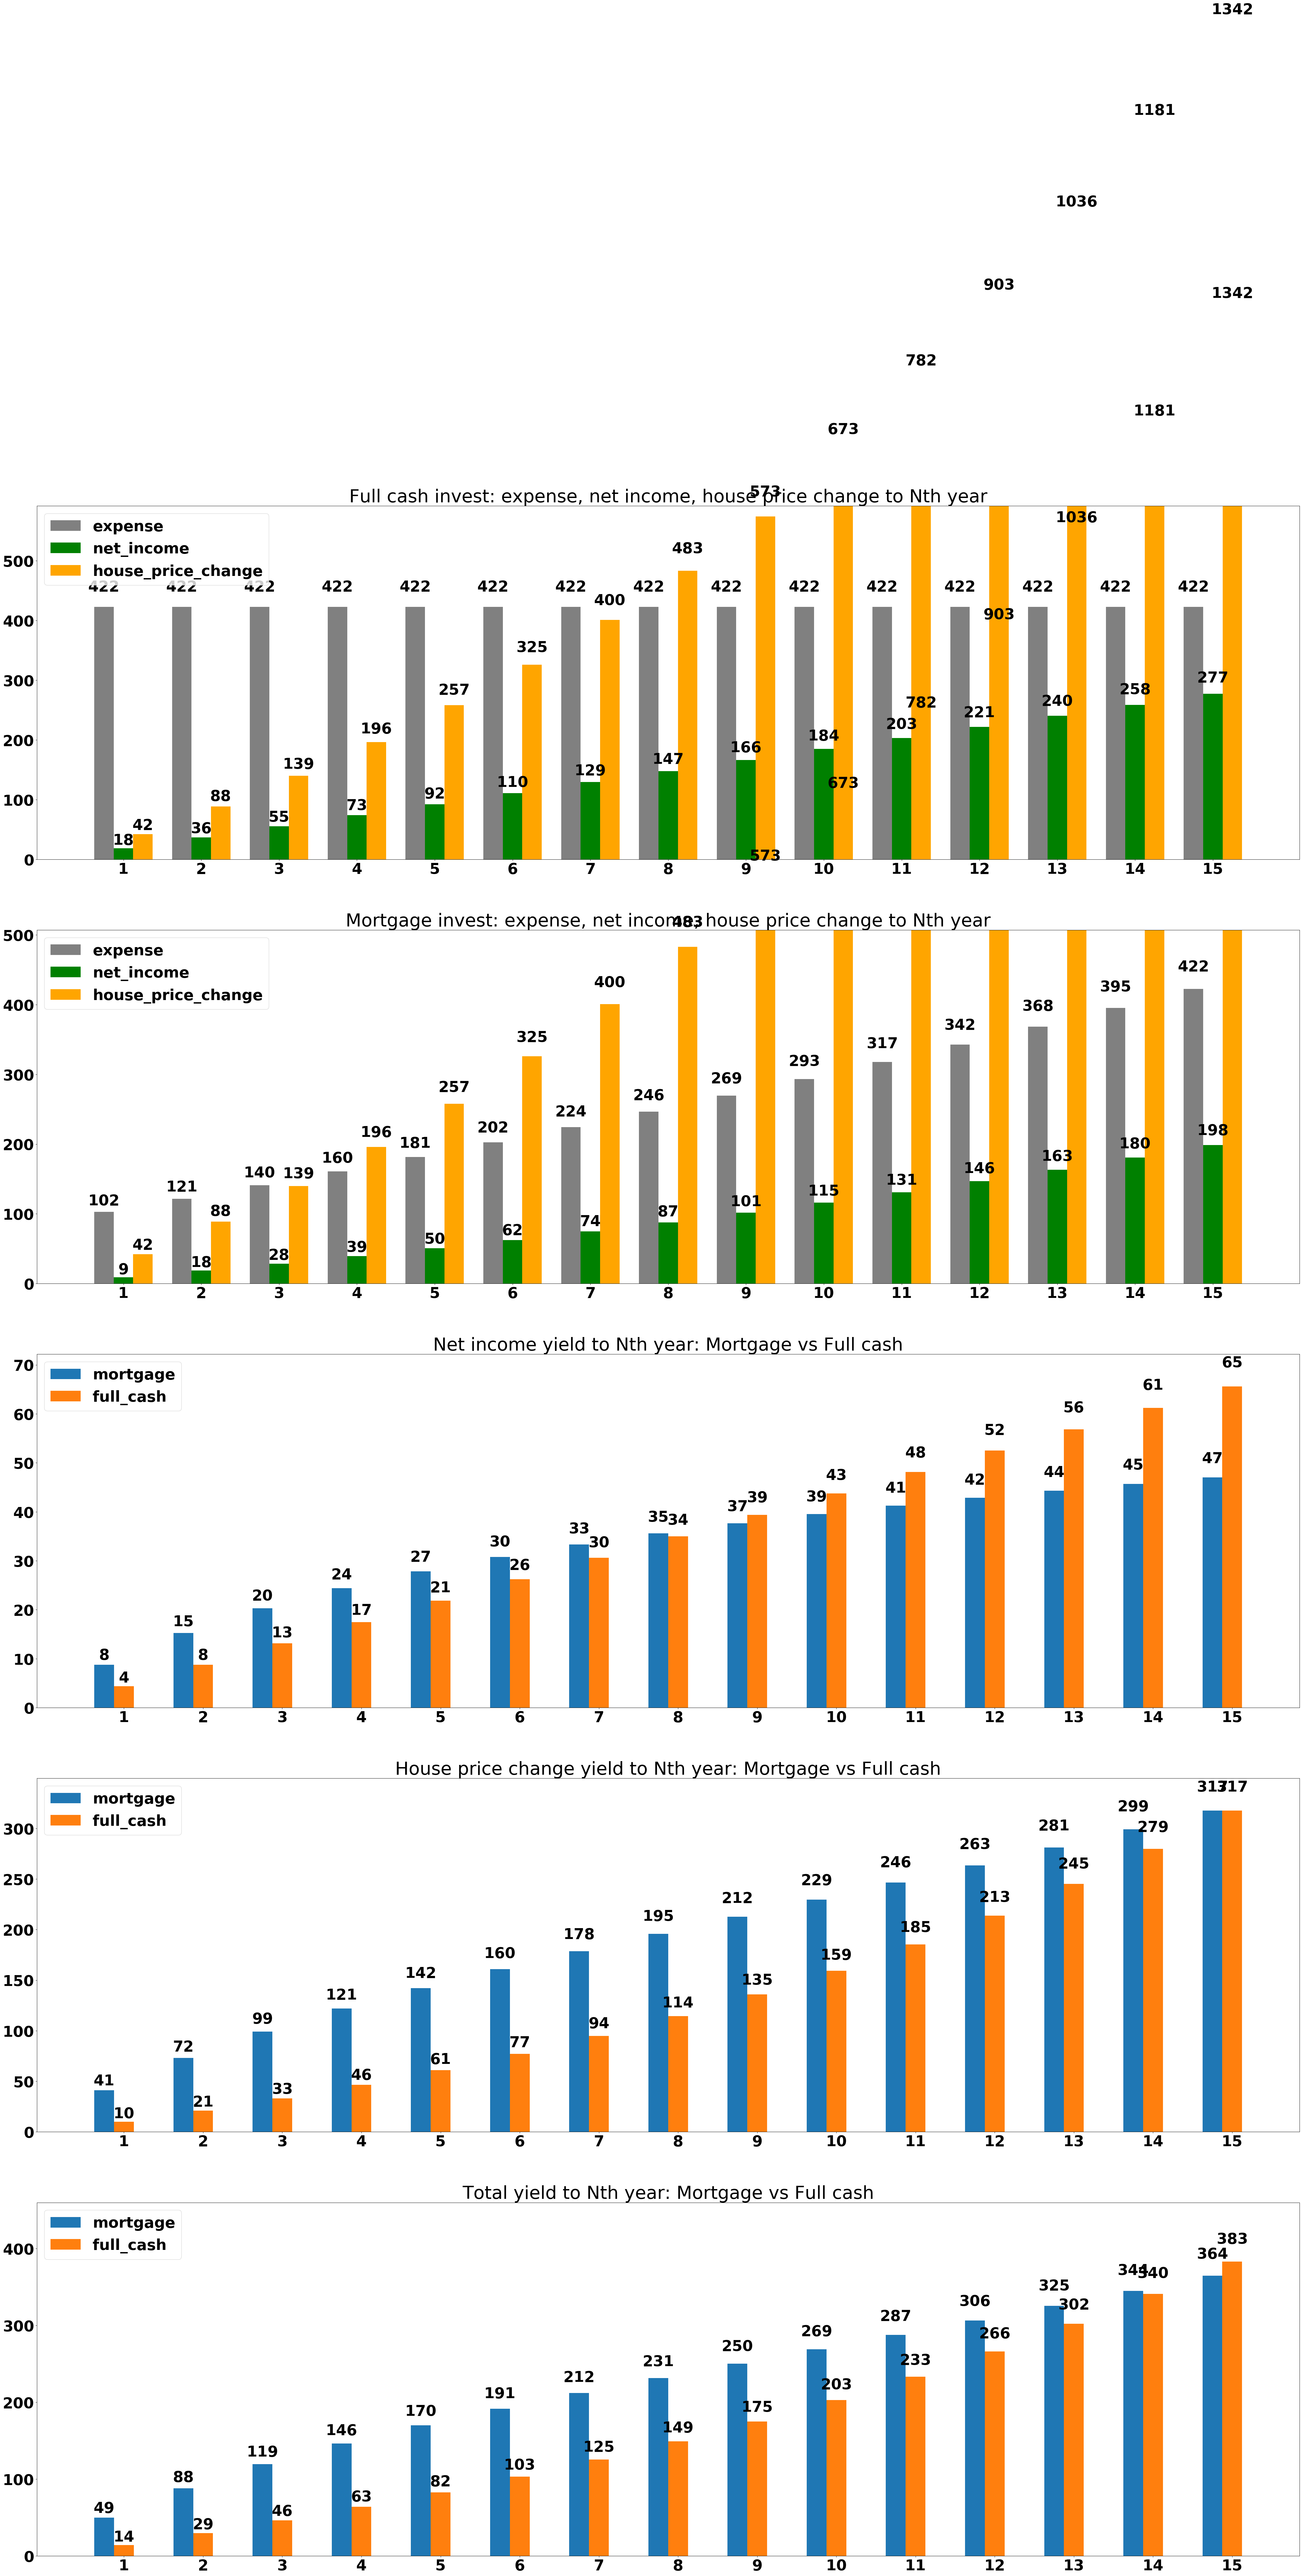

In [206]:
font = {'weight' : 'bold',
        'size'   : 40}
figure(num=None, figsize=(60, 100), dpi=100, facecolor='w', edgecolor='k')

plt.rc('font', **font)
plt.subplot(5,1,1)
width = 0.25
p_expenses = plt.bar(target_yrs-width, [HOUSE_PRICE] * TARGET_YR, width, color='gray')
p_net_income_no_mortgage_acc = plt.bar(target_yrs, acc_net_income_no_mortgage_yr, width, color='green')
p_acc_house_price_change_yr = plt.bar(target_yrs+width, acc_house_price_change_yr, width, color='orange')
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(HOUSE_PRICE, max(acc_net_income_no_mortgage_yr), max(acc_house_price_change_yr)) * 1.4)
plt.legend((p_expenses[0], p_net_income_no_mortgage_acc[0], p_acc_house_price_change_yr[0]),
           ('expense', 'net_income', 'house_price_change'), loc=2)
plt.title("Full cash invest: expense, net income, house price change to Nth year")
autolabel(p_expenses)
autolabel(p_net_income_no_mortgage_acc)
autolabel(p_acc_house_price_change_yr)

plt.subplot(5,1,2)
p_expenses = plt.bar(target_yrs-width, expenses_yr, width, color='gray')
p_acc_net_income_yr = plt.bar(target_yrs, acc_net_income_yr, width, color='green')
p_acc_house_price_change_yr = plt.bar(target_yrs+width, acc_house_price_change_yr, width, color='orange')
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(max(expenses_yr), max(acc_net_income_yr), max(acc_house_price_change_yr)) * 1.2)
plt.legend((p_expenses[0], p_acc_net_income_yr[0], p_acc_house_price_change_yr[0]),
           ('expense', 'net_income', 'house_price_change'))
plt.title("Mortgage invest: expense, net income, house price change to Nth year")
autolabel(p_expenses)
autolabel(p_acc_net_income_yr)
autolabel(p_acc_house_price_change_yr)

plt.subplot(5,1,3)
p_acc_income_yield_ratio_yr = plt.bar(target_yrs - width, acc_income_yield_ratio_yr, width)
p_acc_income_yield_ratio_no_mortgage_yr = plt.bar(target_yrs, acc_income_yield_ratio_no_mortgage_yr, width)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(max(acc_income_yield_ratio_yr), max(acc_income_yield_ratio_no_mortgage_yr)) * 1.1)
plt.legend((p_acc_income_yield_ratio_yr[0], p_acc_income_yield_ratio_no_mortgage_yr[0]), ('mortgage', 'full_cash'), loc=2)
plt.title("Net income yield to Nth year: Mortgage vs Full cash")
autolabel(p_acc_income_yield_ratio_yr)
autolabel(p_acc_income_yield_ratio_no_mortgage_yr)

plt.subplot(5,1,4)
p_acc_house_price_yield_ratio_yr = plt.bar(target_yrs - width, acc_house_price_yield_ratio_yr, width)
p_acc_house_price_yield_ratio_no_mortgage_yr = plt.bar(target_yrs, acc_house_price_yield_ratio_no_mortgage_yr, width)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(max(acc_house_price_yield_ratio_no_mortgage_yr) * 1.1)
plt.legend((p_acc_house_price_yield_ratio_yr[0], p_acc_house_price_yield_ratio_no_mortgage_yr[0]), ('mortgage', 'full_cash'), loc=2)
plt.title("House price change yield to Nth year: Mortgage vs Full cash")
autolabel(p_acc_house_price_yield_ratio_yr)
autolabel(p_acc_house_price_yield_ratio_no_mortgage_yr)

plt.subplot(5,1,5)
total_yield_ratio_yr = np.array(acc_house_price_yield_ratio_yr) + np.array(acc_income_yield_ratio_yr)
total_yield_ratio_no_mortgage_yr = np.array(acc_house_price_yield_ratio_no_mortgage_yr) + np.array(acc_income_yield_ratio_no_mortgage_yr)
p_acc_yield_ratio_yr = plt.bar(target_yrs - width, total_yield_ratio_yr, width)
p_acc_yield_ratio_no_mortgage_yr = plt.bar(target_yrs, total_yield_ratio_no_mortgage_yr, width)
plt.xticks(target_yrs, target_yrs + 1)
plt.ylim(0, max(total_yield_ratio_no_mortgage_yr) * 1.2)
plt.legend((p_acc_yield_ratio_yr[0], p_acc_yield_ratio_no_mortgage_yr[0]), ('mortgage', 'full_cash'), loc=2)
plt.title("Total yield to Nth year: Mortgage vs Full cash")
autolabel(p_acc_yield_ratio_yr)
autolabel(p_acc_yield_ratio_no_mortgage_yr)


#
# plt.savefig("Acc_year_chart{}.png".format(ts))
print("Done!")


In [ ]:
# 如果没有更好的投资策略把杠杠节省下的本金进行投资，那么第一年的高yield下的net income会在n年后稀释，用来除的分母会逐渐变大。如果只有房子
# 作为投资, 应该考虑上图累积图的break even点参考。